# Evolution of decision-consistent biases

+ Behavior data and model predictions for Figures 4

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.patches import Ellipse

from scipy.stats import wilcoxon, pearsonr, spearmanr
from statsmodels.stats.weightstats import DescrStatsW

from dynamic_bias import utils
utils.setup_matplotlib()

In [2]:
utils.download_dataset("data/outputs/ddm")

dcbs_behav      = utils.load(f'{utils.ORIGIN}/data/outputs/behavior/results_decision_consistent_bias.pickle')
dcbs_behav_boot = utils.load(f'{utils.ORIGIN}/data/outputs/behavior/bootstrap_decision_consistent_bias_fixed_points.pickle')
dcbs_behav_perm = utils.load(f'{utils.ORIGIN}/data/outputs/behavior/permutation_decision_consistent_bias_fixed_points.pickle')
dcbs_ddm        = utils.load(f'{utils.ORIGIN}/data/outputs/ddm/results_decision_consistent_bias.pickle')
dcbs_ddm_fxpt   = utils.load(f'{utils.ORIGIN}/data/outputs/ddm/results_decision_consistent_bias_fixed_points.pickle')

downloading data/outputs/ddm...
data/outputs/ddm already exists. Skipping download...


---
## Assay of biases before and after decision-making

In [3]:
regress_params = {}
regress_params['human'] = {
    k: v for k,v in zip(['c','p','s'], utils.simple_linregress(
        dcbs_behav['d_bpre'], dcbs_behav['d_bpost'],
        return_p_value=True, return_residual_variance=True
    ))
}

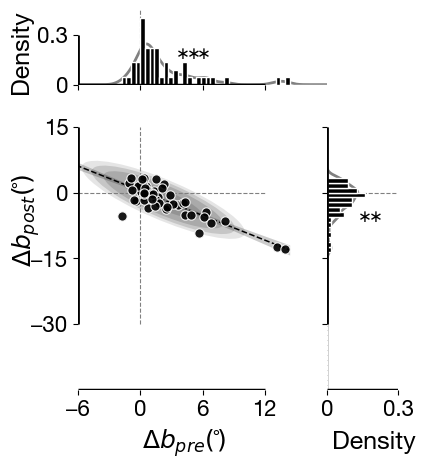

In [4]:
lim = 12
xlim, ylim = 18, 45
f, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [3.5, 1], 'height_ratios': [1, 3.5], 'hspace' : 0.25, 'wspace' : 0})

utils.set_size([3.2, 3.8])

# main scatter plot
ax[1,0].vlines(x=0, ymin=-30, ymax=15, linestyle='dashed', color='gray', linewidth=0.8)
ax[1,0].hlines(y=0, xmin=-6,  xmax=12, linestyle='dashed', color='gray', linewidth=0.8)
ax[1,0].scatter(dcbs_behav['d_bpre'], dcbs_behav['d_bpost'], color='k', edgecolor='w', alpha=0.9, s=45, linewidth=0.8, zorder=3)

# plot regression line
x_line = np.linspace(-lim, lim * 1.2, 100)
y_line = regress_params['human']['c']['intercept'] + x_line*regress_params['human']['c']['slope']
s_line = utils.se_line(x_line, dcbs_behav['d_bpre'], regress_params['human']['s'])

ax[1,0].plot(x_line, y_line, color='k', linewidth=1.1, linestyle='dashed')
ax[1,0].fill_between(x_line, y_line - s_line, y_line + s_line, color='k', alpha=0.2, linewidth=0, zorder=-3)

# isoprobability ellipse
for prob, alph in zip( [0.95, 0.9, 0.8, 0.5], [0.2, 0.3, 0.4, 0.5] ):
    pnt, prm = utils.isoprob_ellipse(np.stack([dcbs_behav['d_bpre'], dcbs_behav['d_bpost']]).T, prob=prob)
    ax[1,0].add_patch(Ellipse(**prm, facecolor='gray', zorder=-5, alpha=alph, lw=0))

ax[1,0].set_xlim([-xlim/3, xlim/1])
ax[1,0].set_ylim([-ylim/1, ylim/3])

# d_pre histogram on the top
ax[0,0].axvline(x=0, linestyle='dashed', color='gray', linewidth=0.8, zorder=-3)
ax[0,0].hist(dcbs_behav['d_bpre'], bins=80, range=[-xlim, xlim], color='k', edgecolor='w', 
             orientation='vertical', density=True)
xvals = np.linspace(-xlim, xlim, 1000)
yvals = utils.kde1d(xvals, dcbs_behav['d_bpre'], bw=0.2)
ax[0,0].plot(xvals, yvals, color='gray', zorder=-3, lw=2)
ax[0,0].set_ylim([0, 0.45])
ax[0,0].set_xlim([-xlim/3, xlim/1])

# d_post histogram on the right
ax[1,1].axhline(y=0, linestyle='dashed', color='gray', linewidth=0.8, zorder=-3)
ax[1,1].hist(dcbs_behav['d_bpost'], bins=80, range=[-ylim, ylim], color='k', edgecolor='w',
             orientation='horizontal', density=True)
xvals = np.linspace(-ylim, ylim, 1000)
yvals = utils.kde1d(xvals, dcbs_behav['d_bpost'], bw=0.25)
ax[1,1].plot(yvals, xvals, color='gray', zorder=-3, lw=2)
ax[1,1].set_xlim([0, 0.3])
ax[1,1].set_ylim([-ylim/1, ylim/3])

ax[0,0].set_yticks([0,0.3])
ax[0,0].set_yticklabels(['0','0.3'])
ax[0,0].set_xticklabels([])
ax[1,1].set_xticks([0,0.3])
ax[1,1].set_xticklabels(['0','0.3'])
ax[1,1].set_yticklabels([])

utils.draw_publish_axis(ax[0,0], tight_layout=False, xrange=(-6,12), yrange=(0,0.3),  xticks=[-6,0,6,12], yticks=[0,0.3])
utils.draw_publish_axis(ax[1,0], tight_layout=False, xrange=(-6,12), yrange=(-30,15), xticks=[-6,0,6,12], yticks=[-30,-15,0,15])
utils.draw_publish_axis(ax[1,1], tight_layout=False, xrange=(0,0.3), yrange=(-30,15), xticks=[0,0.3],     yticks=[-30,-15,0,15])

# remove the empty top-right subplot
ax[0,1].axis('off')

if utils.LABEL:
    kwargs = dict(fontsize=18, transform=plt.gcf().transFigure)
    plt.text(-0.04,  0.72, 'Density', rotation=90, **kwargs)
    plt.text(-0.04,  0.38, r"$\Delta b_{post}(\!\!^\circ\!\!)$", rotation=90, **kwargs)
    plt.text( 0.28, -0.01, r"$\Delta b_{pre}(\!\!^\circ\!\!)$", **kwargs)
    plt.text( 0.74, -0.01, 'Density', **kwargs)
    
    kwargs = dict(fontsize=12, transform=plt.gcf().transFigure)
    plt.text( 0.36,  0.78, r"$ {\ast\!\!\ast\!\!\!\!\ast} $", **kwargs)
    plt.text( 0.80,  0.45, r"$ {\ast\!\!\ast} $", **kwargs)

plt.savefig(f'{utils.DIR_FIGURE}/fig4e.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [5]:
spear = spearmanr(dcbs_behav['d_bpre'],dcbs_behav['d_bpost'])
pears = pearsonr(dcbs_behav['d_bpre'],dcbs_behav['d_bpost'])
pears_CI = utils.pearson_CI(dcbs_behav['d_bpre'],dcbs_behav['d_bpost'])
print('Behavior : Relation between d_bpre and d_bpost')
print('\nLinear regression')
print(f"Coefficient: {regress_params['human']['c']['slope']}")
print(f"p-value: {regress_params['human']['p']['slope']}")
print('\nCorrelation coefficient')
print('Pearson r=', pears[0], 'p=', pears[1])
print('Pearson CI=', pears_CI)
print('Spearman rho=', spear.correlation, 'p=', spear.pvalue)

print("\nΔb_pre vs. 0")
ttest  = DescrStatsW(dcbs_behav['d_bpre'])
wilcox = wilcoxon(dcbs_behav['d_bpre'])
print('One-sample t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('Wilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

print("\nΔb_post vs. 0")
ttest  = DescrStatsW(dcbs_behav['d_bpost'])
wilcox = wilcoxon(dcbs_behav['d_bpost'])
print('One-sample t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('Wilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

Behavior : Relation between d_bpre and d_bpost

Linear regression
Coefficient: -0.9399076690986012
p-value: 9.90825945445331e-14

Correlation coefficient
Pearson r= -0.8294597868820903 p= 9.908259454453145e-14
Pearson CI= (-0.9000138844357352, -0.7165472315393313)
Spearman rho= -0.6636734693877551 p= 1.4947629709848992e-07

Δb_pre vs. 0
One-sample t-test
t(49)= 4.866675816545377 p= 1.2201855568846857e-05
95% CI= (1.2986795929255242, 3.1255626672354047)
Wilcoxon signed-rank test (without continuity correction)
V= 124.0 p= 6.220717985172541e-08

Δb_post vs. 0
One-sample t-test
t(49)= -3.2341636191513046 p= 0.002186658776192516
95% CI= (-2.700893122403202, -0.6307488679785134)
Wilcoxon signed-rank test (without continuity correction)
V= 354.0 p= 0.005579489549422334


Drift-diffusion model


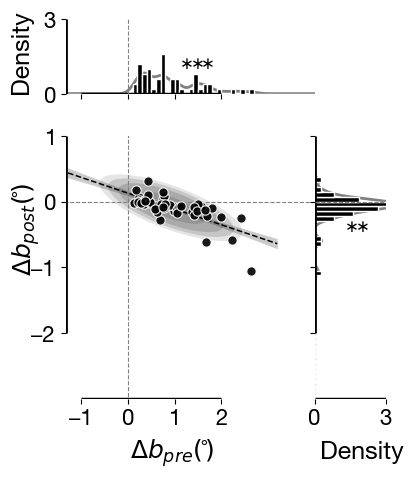

DDM - Relation between d_bpre and d_bpost

Linear regression
Coefficient: -0.24023843321940055
p-value: 2.4383198969264995e-09

Correlation coefficient
Pearson r= -0.7259551048619961 p= 2.4383198969264833e-09
Pearson CI= (-0.8354792470227306, -0.5609592756157047)
Spearman rho= -0.7496278511404562 p= 3.7535070834907076e-10

Δb_pre vs. 0
One-sample t-test
t(49)= 10.38478578419238 p= 5.66275605055973e-14
95% CI= (0.7427142132818947, 1.0991327368418378)
Wilcoxon signed-rank test (without continuity correction)
V= 0.0 p= 1.7763568394002505e-15

Δb_post vs. 0
One-sample t-test
t(49)= -3.2024586928664904 p= 0.002395099205083358
95% CI= (-0.15295580307956075, -0.035007148821264544)
Wilcoxon signed-rank test (without continuity correction)
V= 253.0 p= 0.00011903464815610221


Diffusion-only model


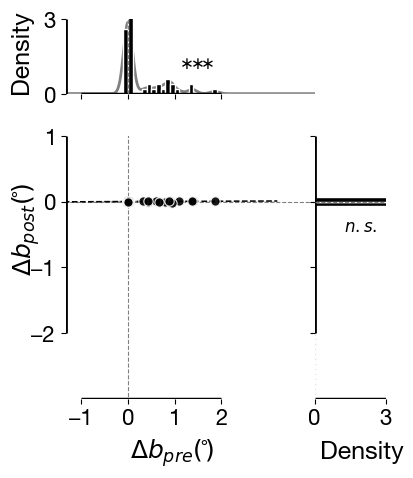

DDM - Relation between d_bpre and d_bpost

Linear regression
Coefficient: 0.0026970026317009468
p-value: 0.15680039573291596

Correlation coefficient
Pearson r= 0.2032845262671466 p= 0.15680039573291588
Pearson CI= (-0.07956529789947855, 0.4558391412438456)
Spearman rho= 0.2163265306122449 p= 0.1313241882758723

Δb_pre vs. 0
One-sample t-test
t(49)= 4.276054204548148 p= 8.768540656189698e-05
95% CI= (0.15085597748604399, 0.41836910276576555)
Wilcoxon signed-rank test (without continuity correction)
V= 211.0 p= 1.5207189122179443e-05

Δb_post vs. 0
One-sample t-test
t(49)= 0.5389469063544278 p= 0.5923638618091273
95% CI= (-0.00129864606854243, 0.0022504858606916507)
Wilcoxon signed-rank test (without continuity correction)
V= 600.0 p= 0.7232586770768918


In [6]:
regress_params['ddm'] = {}
for i_models, v_models in enumerate(['full', 'reduced']):

    if i_models == 0:
        print('Drift-diffusion model')
    if i_models == 1:
        print('\n\nDiffusion-only model')

    # np.random.seed(2023)
    d_bpre  = dcbs_ddm[v_models]['d_bpre']
    d_bpost = dcbs_ddm[v_models]['d_bpost']

    # regression
    regress_params['ddm'][v_models] = {
        k: v for k,v in zip(['c','p','s'], utils.simple_linregress(
            d_bpre, d_bpost, return_p_value=True, return_residual_variance=True
        ))
    }

    lim, xlim, ylim = 4, 4, 3
    f, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [3.5, 1], 'height_ratios': [1, 3.5], 'hspace' : 0.25, 'wspace' : 0})
    utils.set_size([3.2, 3.8])

    # main scatter plot
    ax[1,0].vlines(x=0, ymin=-30, ymax=15, linestyle='dashed', color='gray', linewidth=0.8)
    ax[1,0].hlines(y=0, xmin=-6,  xmax=12, linestyle='dashed', color='gray', linewidth=0.8)
    ax[1,0].scatter(d_bpre, d_bpost, color='k', edgecolor='w', alpha=0.9, s=45, linewidth=0.8, zorder=3)

    # plot regression line
    x_line  = np.linspace(-lim, lim*0.8, 100)
    y_line = regress_params['ddm'][v_models]['c']['intercept'] + x_line*regress_params['ddm'][v_models]['c']['slope']
    s_line = utils.se_line(x_line, d_bpre, regress_params['ddm'][v_models]['s'])

    ax[1,0].plot(x_line, y_line, color='k', linewidth=1.1, linestyle='dashed')
    ax[1,0].fill_between(x_line, y_line - s_line, y_line + s_line, color='k', alpha=0.2, linewidth=0, zorder=-3)

    # isoprobability ellipse
    for prob, alph in zip( [0.95, 0.9, 0.8, 0.5], [0.2, 0.3, 0.4, 0.5] ):
        pnt, prm = utils.isoprob_ellipse(np.stack([d_bpre, d_bpost]).T, prob=prob)
        ax[1,0].add_patch(Ellipse(**prm, facecolor='gray', zorder=-5, alpha=alph, lw=0))

    ax[1,0].set_xlim([-xlim/3, xlim/1])
    ax[1,0].set_ylim([-ylim/1, ylim/3])

    # d_pre histogram on the top
    ax[0,0].axvline(x=0, linestyle='dashed', color='gray', linewidth=0.8, zorder=3)
    ax[0,0].hist(d_bpre, bins=80, range=[-xlim, xlim], color='k', edgecolor='w', 
                orientation='vertical', density=True)
    xvals = np.linspace(-xlim, xlim, 1000)
    yvals = utils.kde1d(xvals, d_bpre, bw=0.2)
    ax[0,0].plot(xvals, yvals, color='gray', zorder=-3, lw=2)
    ax[0,0].set_ylim([0, 0.45])
    ax[0,0].set_xlim([-xlim/3, xlim/1])

    # d_post histogram on the right
    ax[1,1].axhline(y=0, linestyle='dashed', color='gray', linewidth=0.8, zorder=3)
    ax[1,1].hist(d_bpost, bins=80, range=[-ylim, ylim], color='k', edgecolor='w',
                orientation='horizontal', density=True)
    xvals = np.linspace(-ylim, ylim, 1000)
    yvals = utils.kde1d(xvals, d_bpost, bw=0.25)
    ax[1,1].plot(yvals, xvals, color='gray', zorder=-3, lw=2)
    ax[1,1].set_xlim([0, 3])
    ax[1,1].set_ylim([-ylim/1, ylim/3])

    ax[0,0].set_yticks([0,3])
    ax[0,0].set_yticklabels(['0','3'])
    ax[0,0].set_xticklabels([])
    ax[1,1].set_xticks([0,3])
    ax[1,1].set_xticklabels(['0','3'])
    ax[1,1].set_yticklabels([])

    utils.draw_publish_axis(ax[0,0], tight_layout=False, xrange=(-1,2), yrange=(0,3),  xticks=[-1,0,1,2], yticks=[0,3])
    utils.draw_publish_axis(ax[1,0], tight_layout=False, xrange=(-1,2), yrange=(-2,1), xticks=[-1,0,1,2], yticks=[-2,-1,0,1])
    utils.draw_publish_axis(ax[1,1], tight_layout=False, xrange=(0,3), yrange=(-2,1),  xticks=[0,3],      yticks=[-2,-1,0,1])

    # remove the empty top-right subplot
    ax[0,1].axis('off')

    if utils.LABEL:
        kwargs = dict(fontsize=18, transform=plt.gcf().transFigure)
        plt.text(-0.01,  0.74, 'Density', rotation=90, **kwargs)
        plt.text(-0.01,  0.38, r"$\Delta b_{post}(\!\!^\circ\!\!)$", rotation=90, **kwargs)
        plt.text( 0.28, -0.01, r"$\Delta b_{pre}(\!\!^\circ\!\!)$", **kwargs)
        plt.text( 0.74, -0.01, 'Density', **kwargs)
        
        kwargs = dict(fontsize=12, transform=plt.gcf().transFigure)
        if i_models == 0:
            plt.text( 0.40,  0.78, r"$ {\ast\!\!\ast\!\!\!\!\ast} $", **kwargs)
            plt.text( 0.80,  0.45, r"$ {\ast\!\!\ast} $", **kwargs)

        if i_models == 1:
            plt.text( 0.40,  0.78, r"$ {\ast\!\!\ast\!\!\!\!\ast} $", **kwargs)
            plt.text( 0.80,  0.45, r"$n.s.\!\!$", **kwargs)

    fign = ['g','i'][i_models]
    plt.savefig(f'{utils.DIR_FIGURE}/fig4{fign}.pdf', bbox_inches='tight', transparent=True)
    plt.show()

    # ====================
    # analysis results
    # ====================
    spear = spearmanr(d_bpre,d_bpost)
    pears = pearsonr(d_bpre,d_bpost)
    pears_CI = utils.pearson_CI(d_bpre,d_bpost)
    print('DDM - Relation between d_bpre and d_bpost')
    print('\nLinear regression')
    print(f"Coefficient: {regress_params['ddm'][v_models]['c']['slope']}")
    print(f"p-value: {regress_params['ddm'][v_models]['p']['slope']}")
    print('\nCorrelation coefficient')
    print('Pearson r=', pears[0], 'p=', pears[1])
    print('Pearson CI=', pears_CI)
    print('Spearman rho=', spear.correlation, 'p=', spear.pvalue)

    print("\nΔb_pre vs. 0")
    ttest  = DescrStatsW(d_bpre)
    wilcox = wilcoxon(d_bpre)
    print('One-sample t-test')
    print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
    print('95% CI=', ttest.tconfint_mean())
    print('Wilcoxon signed-rank test (without continuity correction)')
    print('V=', wilcox[0], 'p=', wilcox[1])

    print("\nΔb_post vs. 0")
    ttest  = DescrStatsW(d_bpost)
    wilcox = wilcoxon(d_bpost)
    print('One-sample t-test')
    print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
    print('95% CI=', ttest.tconfint_mean())
    print('Wilcoxon signed-rank test (without continuity correction)')
    print('V=', wilcox[0], 'p=', wilcox[1])

---
## Assay of biases around fixed points

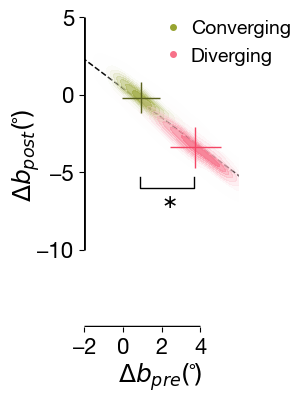

In [7]:
# colors
N_VIS = 500 # number of samples to visualize
cmps = {
    'converging' : utils.interp_colormap(color_u=utils.HUSL.colors[6]+(1,)),
    'diverging'  : utils.interp_colormap(color_u=utils.HUSL.colors[0]+(1,))
}

plt.figure()
ax = plt.gca()
utils.set_size([2.1, 3])

# plot KDE plots for 'converging' and 'diverging'
for i_cond, cond in enumerate(['converging', 'diverging']):
    dbpre_m,  dbpre_s  = utils.meanstats(dcbs_behav_boot['d_bpre'][cond], median=True, sd=True)
    dbpost_m, dbpost_s = utils.meanstats(dcbs_behav_boot['d_bpost'][cond], median=True, sd=True)

    # KDE plot for pre and post
    sns.kdeplot(x=dcbs_behav_boot['d_bpre'][cond][:N_VIS], y=dcbs_behav_boot['d_bpost'][cond][:N_VIS],
                cmap=cmps[cond], fill=True, thresh=0.001, levels=9)
    
    plt.vlines(dbpre_m, dbpost_m - dbpost_s, dbpost_m + dbpost_s,
               color=utils.lighten_color(cmps[cond].colors[-1], 1.3), linewidth=1)
    plt.hlines(dbpost_m, dbpre_m - dbpre_s, dbpre_m + dbpre_s,
               color=utils.lighten_color(cmps[cond].colors[-1], 1.3), linewidth=1)


# Add lines and labels for clarity
xl, xr = 0.9, 3.7
plt.plot([xl, xl, xr, xr], [-5.3, -6, -6, -5.3], lw=1, c='k')
plt.text((xl+xr)/2., -7.5, r"$\,{\ast}$", ha='center', va='bottom', color='k', fontsize=14)

#
kwargs = dict(marker='o', markersize=4, linestyle='None')
circ1 = mlines.Line2D([], [], color=cmps['converging'](1.0), label='Converging', **kwargs)
circ2 = mlines.Line2D([], [], color=cmps['diverging'](1.0),  label='Diverging', **kwargs)
plt.legend(handles=[circ1, circ2], frameon=False, loc=(0.4,0.82), fontsize=14, handletextpad=-0.1)

#
lim = 8
x_line = np.linspace(-lim, lim * 1.2, 100)
y_line = regress_params['human']['c']['intercept'] + x_line*regress_params['human']['c']['slope']
plt.plot(x_line, y_line, color='k', linewidth=1.1, zorder=-3, linestyle='dashed')

#
div = 2
xlim, ylim = 12 / div, 30 / div
plt.xlim([-xlim / 3, xlim / 1])
plt.ylim([-ylim / 1, ylim / 3])
utils.draw_publish_axis(ax, xrange=(-4 / div, 8 / div), yrange=(-20 / div, 10 / div), 
                        xticks=[-4 / div, 0, 4 / div, 8 / div], yticks=[-20 / div, -10 / div, 0, 10 / div])

if utils.LABEL:
    kwargs = dict(fontsize=18, transform=plt.gcf().transFigure)
    plt.text(-0.02,  0.48, r"$\Delta b_{post}(\!\!^\circ\!\!)$", rotation=90, **kwargs)
    plt.text( 0.38, -0.01, r"$\Delta b_{pre}(\!\!^\circ\!\!)$", **kwargs)

plt.savefig(f'{utils.DIR_FIGURE}/fig4f.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [8]:
print("diverging and converging when projected onto the regression line")

# projections on the regression line
proj_obs  = {}
proj_null = {}
for g in ['diverging', 'converging']:
    ## observation
    proj = np.stack([dcbs_behav_perm['obs']['d_bpre'][g], dcbs_behav_perm['obs']['d_bpost'][g]],axis=-1)
    proj_obs[g] = utils.project(proj, slope=regress_params['human']['c']['slope'])

    ## null
    proj = np.stack([dcbs_behav_perm['null']['d_bpre'][g], dcbs_behav_perm['null']['d_bpost'][g]],axis=-1)
    proj_null[g] = utils.project(proj, slope=regress_params['human']['c']['slope'])

print("\nProjected Euclidean distance between diverging and converging groups")
dist_obs = proj_obs['diverging'] - proj_obs['converging']
print('Distance:', np.linalg.norm(dist_obs))

print("\nBootstrap test: projected distance between diverging and converging groups (one-sided)")
dist_null = proj_null['diverging'] - proj_null['converging']
print('p-value:', utils.permutation_test(dist_obs[0,0], dist_null[:,0], alternative='greater'))

diverging and converging when projected onto the regression line

Projected Euclidean distance between diverging and converging groups
Distance: 4.214577778580157

Bootstrap test: projected distance between diverging and converging groups (one-sided)
p-value: 0.0457


Drift-diffusion model


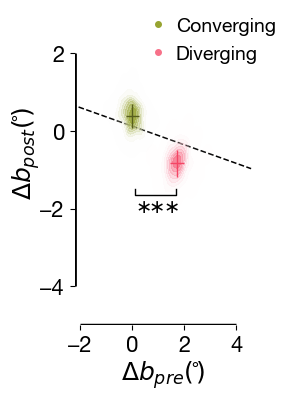

d_bpre - d_bpost in diverging and converging stimuli
H0: (Δd_bpre, Δd_bpost) = (0,0)
H1: (Δd_bpre, Δd_bpost) = (+,-) (difference towards 4th quadrant)

Bootstrap test
diverging and converging when projected onto the regression line

Projected Euclidean distance between diverging and converging groups
Distance: 1.9412785680213072

Bootstrap test: projected distance between diverging and converging groups (one-sided)
p-value: 0.0


Diffusion-only model


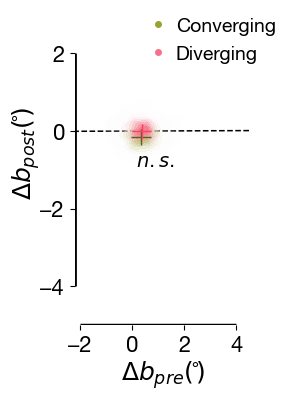

d_bpre - d_bpost in diverging and converging stimuli
H0: (Δd_bpre, Δd_bpost) = (0,0)
H1: (Δd_bpre, Δd_bpost) = (+,-) (difference towards 4th quadrant)

Bootstrap test
diverging and converging when projected onto the regression line

Projected Euclidean distance between diverging and converging groups
Distance: 0.015146026302971792

Bootstrap test: projected distance between diverging and converging groups (one-sided)
p-value: 0.4979


In [9]:
for i_models, v_models in enumerate(['full', 'reduced']):

    if i_models == 0:
        print('Drift-diffusion model')
    if i_models == 1:
        print('\n\nDiffusion-only model')

    plt.figure()
    ax = plt.gca()
    utils.set_size([2.1, 3])

    # plot KDE plots for 'converging' and 'diverging'
    for i_cond, cond in enumerate(['converging', 'diverging']):

        dbpre_m,  dbpre_s  = utils.meanstats(dcbs_ddm_fxpt['boot'][v_models]['d_bpre'][cond], median=True, sd=True)
        dbpost_m, dbpost_s = utils.meanstats(dcbs_ddm_fxpt['boot'][v_models]['d_bpost'][cond], median=True, sd=True)

        # KDE plot for pre and post
        sns.kdeplot(x=dcbs_ddm_fxpt['boot'][v_models]['d_bpre'][cond][:N_VIS], 
                    y=dcbs_ddm_fxpt['boot'][v_models]['d_bpost'][cond][:N_VIS],
                    cmap=cmps[cond], fill=True, thresh=0.001, levels=9)
        
        plt.vlines(dbpre_m, dbpost_m - dbpost_s, dbpost_m + dbpost_s,
                color=utils.lighten_color(cmps[cond].colors[-1], 1.3), linewidth=1)
        plt.hlines(dbpost_m, dbpre_m - dbpre_s, dbpre_m + dbpre_s,
                color=utils.lighten_color(cmps[cond].colors[-1], 1.3), linewidth=1)


    #
    kwargs = dict(marker='o', markersize=4, linestyle='None')
    circ1 = mlines.Line2D([], [], color=cmps['converging'](1.0), label='Converging', **kwargs)
    circ2 = mlines.Line2D([], [], color=cmps['diverging'](1.0),  label='Diverging', **kwargs)
    plt.legend(handles=[circ1, circ2], frameon=False, loc=(0.3,0.82), fontsize=14, handletextpad=-0.1)

    #
    lim = 3.8
    x_line = np.linspace(-lim, lim * 1.2, 100)
    y_line = regress_params['ddm'][v_models]['c']['intercept'] + x_line*regress_params['ddm'][v_models]['c']['slope']
    plt.plot(x_line, y_line, color='k', linewidth=1.1, zorder=-3, linestyle='dashed')

    if i_models == 0:
        xl, xr = 0.1, 1.7
        plt.plot([xl, xl, xr, xr], [-1.5, -1.65, -1.65, -1.5], lw=1, c='k')
        plt.text((xl+xr)/2., -2.2, r"$\,{\ast\!\!\ast\!\!\!\ast}$", ha='center', va='bottom', color='k', fontsize=14)
    if i_models == 1:
        plt.text((xl+xr)/2., -1.0, r"$n.s.\!\!$", ha='center', va='bottom', color='k', fontsize=14)

    #
    # plt.xlim([-1.5,3.8])
    # plt.ylim([-3.5,2.0])
    plt.xlim([-2.2,5])
    plt.ylim([-5,3])
    # utils.draw_publish_axis(ax, xrange=(-1,2), yrange=(-2,1), xticks=[-1,0,1,2], yticks=[-2,-1,0,1])
    utils.draw_publish_axis(ax, xrange=(-2,4), yrange=(-4,2), xticks=[-2,0,2,4], yticks=[-4,-2,0,2])

    if utils.LABEL:
        kwargs = dict(fontsize=18, transform=plt.gcf().transFigure)
        plt.text(-0.03,  0.48, r"$\Delta b_{post}(\!\!^\circ\!\!)$", rotation=90, **kwargs)
        plt.text( 0.38, -0.01, r"$\Delta b_{pre}(\!\!^\circ\!\!)$", **kwargs)

    fign = ['h','j'][i_models]
    plt.savefig(f'{utils.DIR_FIGURE}/fig4{fign}.pdf', bbox_inches='tight', transparent=True)
    plt.show()

    # boostrap test
    print("d_bpre - d_bpost in diverging and converging stimuli")
    print("H0: (Δd_bpre, Δd_bpost) = (0,0)")
    print("H1: (Δd_bpre, Δd_bpost) = (+,-) (difference towards 4th quadrant)")

    print("\nBootstrap test")
    dcb_boot_test_array = np.stack([
        dcbs_ddm_fxpt['boot'][v_models]['d_bpre']['diverging']   - dcbs_ddm_fxpt['boot'][v_models]['d_bpre']['converging'],
        dcbs_ddm_fxpt['boot'][v_models]['d_bpost']['converging'] - dcbs_ddm_fxpt['boot'][v_models]['d_bpost']['diverging'],
    ], axis=-1)

    # projections on the regression line
    print("diverging and converging when projected onto the regression line")
    proj_obs  = {}
    proj_null = {}
    for g in ['diverging', 'converging']:
        ## observation
        m_pre  = np.mean( dcbs_ddm_fxpt['boot'][v_models]['d_bpre'][g] )
        m_post = np.mean( dcbs_ddm_fxpt['boot'][v_models]['d_bpost'][g] )
        proj = np.stack([[m_pre], [m_post]],axis=-1)
        proj_obs[g] = utils.project(proj, slope=regress_params['ddm'][v_models]['c']['slope'])

        ## null
        proj = np.stack([dcbs_ddm_fxpt['perm'][v_models]['d_bpre'][g], dcbs_ddm_fxpt['perm'][v_models]['d_bpost'][g]],axis=-1)
        proj_null[g] = utils.project(proj, slope=regress_params['ddm'][v_models]['c']['slope'])

    print("\nProjected Euclidean distance between diverging and converging groups")
    dist_obs = proj_obs['diverging'] - proj_obs['converging']
    print('Distance:', np.linalg.norm(dist_obs))

    print("\nBootstrap test: projected distance between diverging and converging groups (one-sided)")
    dist_null = proj_null['diverging'] - proj_null['converging']
    print('p-value:', utils.permutation_test(dist_obs[0,0], dist_null[:,0], alternative='greater'))